In [ ]:
import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

path = '/content/drive/MyDrive/Cats and Dogs/';
cat_matrix = np.load(path+'allCatNumpy.npy');
dog_matrix = np.load(path+'allDogNumpy.npy');
print(np.shape(cat_matrix));
print(np.shape(dog_matrix))

(1000, 204800)
(1000, 204800)


In [ ]:
all_data = np.concatenate((cat_matrix,dog_matrix));
print(np.shape(all_data))
# We need to center the data
means = np.mean(all_data,axis=0)
all_data = all_data - means
cat_matrix = cat_matrix - means
dog_matrix = dog_matrix - means

(2000, 204800)


In [ ]:
# I seek the first 2 eigenvectors of XX^T. Unfortunately, this
# is a 204,800 x 204,800 matrix which is much too big to store
# in ram. I do not know how to compute the first 2 eigenvectors
# Via any package provided by python, although I am sure there
# is some option out there. What I do know is in cases like 
# these, one option is a subspace iteration method. This is
# based on the idea that for any k-Dimension subspace Q, XX^TQ, will 
# be more conformal to the subspace spanned by the first 
# k eigenvectors of XX^T than Q.
def calculate_eigenvectors(X,Q,num_iters=100,iterOrder=0,iterOrder2=0):
  # Scaling X does not change the eigenvectors, only the eigenvalues.
  # This should help things to not blow up
  X = X/np.linalg.norm(X);
  lambdas = np.zeros(np.shape(Q)[1]);
  error1 = error2 = 1;
  # Make the columns of Q orthonormal
  [Q, r] = np.linalg.qr(Q);
  # Precomputed iteration matrix
  # K1, K2 is low dimentional.
  # I make use of the fact that while XX^T is very
  # large, X^TX is small, so if we ever have
  # to compute XX^TXX^TXX^T... we can use
  # X(X^TX)^orderX^T
  K1 = np.dot(X,X.T);
  K2 = copy.deepcopy(K1);
  for j in range(0,iterOrder):
    K1 = np.dot(K1,K1);
  for j in range(0,iterOrder):
    K2 = np.dot(K2,K2);
  for i in range(0,num_iters):
    # Set new Q to XX^TQ
    if iterOrder2 > 0:
      Q2 = np.dot(X.T,np.dot(K2,np.dot(X,Q)));
    else :
      Q2 = np.dot(X.T,np.dot(X,Q));
    # Since Q[:,1] converges considerably slower than Q[:,0],
    # I will multiply Q[:,1] by more Powers of XX^T
    if error1/error2 < .05 and iterOrder > 0:
      Q3 = Q2[:,1];
      Q3 = np.dot(X.T,np.dot(K1,np.dot(X,Q3)));
      Q2[:,1] = Q3; 
    # Make the columns orthonormal (only once in a while)
    [Q2, r] = np.linalg.qr(Q2);
    [Q,r] = np.linalg.qr(Q);
    if i % 1 == 0:
      # Gives an idea of the convergence
      error1 = min(np.linalg.norm(Q2[:,0]-Q[:,0]),np.linalg.norm(Q2[:,0]+Q[:,0]));
      error2 = min(np.linalg.norm(Q2[:,1]-Q[:,1]),np.linalg.norm(Q2[:,1]+Q[:,1]));
      print("Iteration "+str(i)+":");
      print("Change in eigenvector 1: "+str(error1));
      print("Change in eigenvector 2: "+str(error2));
    if error1 < .00000000001 and error2 < .00000000001:
      return Q;
    Q = Q2;
  return Q;

In [ ]:
# One way to avoid having to compute eigenvectors of
# the very large 204800 by 204800 matrix is to use KPCA
K = np.dot(all_data,all_data.T);
print(np.shape(K));
# Since all_data is centered in the feature space we
# should not need to center the kernel, but we will just in
# case. To double check our intuition, we can calculate the 
# difference between the two kernel matrices. We expect the
# difference to be 0
U = np.eye(np.shape(K)[0]) - 1/(np.shape(K)[0])*np.ones((np.shape(K)));
KC = np.dot(U,np.dot(K,U));
# We divide by the norm of KC to get a sense of the scale we are dealing
# with. .2 might be large on the scale of 10 to 0, but tiny on the 
# scale of 1000000 to 300000000.
print(np.linalg.norm(KC-K)/np.linalg.norm(KC));
# Indeed KC is about K, So I will just use K, this way, I can get explicit
# form for the eigenvectors.

(2000, 2000)
3.340827023954185e-08


In [ ]:
# Lets now compute the eigenvector eigenvalue pairs for KC. Since KC
# is only 2000 by 2000, we can do this using normal python package
[L,E] = np.linalg.eig(K)
print(L);

[2945997.      894805.94    889975.56   ...    4094.1697    4086.7703
    4052.3245]


In [ ]:
# Since we have an explicit form for q(x), we can use this to 
# compute pair of eigenvectors
Q2 = np.dot(all_data.T,E[:,:5])
# Normalize Q2
Q2[:,0] = Q2[:,0]/np.linalg.norm(Q2[:,0]);
Q2[:,1] = Q2[:,1]/np.linalg.norm(Q2[:,1]);
Q2[:,2] = Q2[:,2]/np.linalg.norm(Q2[:,2]);
Q2[:,3] = Q2[:,3]/np.linalg.norm(Q2[:,3]);
Q2[:,4] = Q2[:,4]/np.linalg.norm(Q2[:,4]);

In [ ]:
# This could take a handfull of minutes. If you want more
# eigenvectors change 2 to however many eigenvectors you want
# What we see here is very quick convergence of the first component
# and much slower convergence of the second component. This
# suggests the eigenvalue of the first component is much larger
# than the eigenvalue of the second component.

# When I plug in the solution from the kernel method, I see right 
# away that this solution is a pair of eigenvectors of the PCA
# method, because the error is small and remains small. Moreover,
# the associated eigenvalues are consistent with being the largest
# 2 eigenvalues. Therefore, we can conclude that both approaches
# result in the same final eigenvector, eigenvalue pairs, but
# the kernel approach is in this case considerably more
Q = calculate_eigenvectors(all_data,Q2)

Iteration 0:
Change in eigenvector 1: 1.9103365e-07
Change in eigenvector 2: 2.1749293e-07
Iteration 1:
Change in eigenvector 1: 6.425567e-08
Change in eigenvector 2: 8.44674e-08
Iteration 2:
Change in eigenvector 1: 5.5415498e-08
Change in eigenvector 2: 7.599632e-08
Iteration 3:
Change in eigenvector 1: 5.4895445e-08
Change in eigenvector 2: 7.567901e-08
Iteration 4:
Change in eigenvector 1: 5.3562562e-08
Change in eigenvector 2: 7.41607e-08
Iteration 5:
Change in eigenvector 1: 5.5158974e-08
Change in eigenvector 2: 7.421969e-08
Iteration 6:
Change in eigenvector 1: 5.5182927e-08
Change in eigenvector 2: 7.404912e-08
Iteration 7:
Change in eigenvector 1: 5.5179537e-08
Change in eigenvector 2: 7.32791e-08
Iteration 8:
Change in eigenvector 1: 5.574698e-08
Change in eigenvector 2: 7.365491e-08
Iteration 9:
Change in eigenvector 1: 5.4997464e-08
Change in eigenvector 2: 7.376787e-08
Iteration 10:
Change in eigenvector 1: 5.4101335e-08
Change in eigenvector 2: 7.3454565e-08
Iteration 11

In [ ]:
# Lets double check that we do indeed have eigenvectors, and 
# lets see what the eigenvalues are. XX^Tq1 = lambda_1 q1
# and XX^Tq2 = lambda_2 q2
answer = np.dot(all_data.T,np.dot(all_data,Q[:,0]))
# Since Q is orthonormal, norm(q1) = 1 and 
# |lambda| = norm(answer)/norm(q1);
# assuming q1[0] is not 0, sign(lambda) = sign(answer[0]*q1[0])
lambda1 = np.linalg.norm(answer)*np.sign(Q[0,0]*answer[0]);
print(lambda1)
# answer / lambda1 should be about q1, Wow, that is a very large 
# lambda1 value. Also, 7.8475 * 10^{-16} is indeed basically 0,
# so we do have an eigenvector, eigenvalue pair.
print(np.linalg.norm(answer/lambda1 - Q[:,0]))

2945995.5
5.4154106e-07


In [ ]:
# By the way, I use answer/lambda2 - Q[:,1] to determine
# if the vectors are similar because I know the norm
# of Q[:,1] is one, whereas the norm of answer is very
# large, this would make the difference of the two vectors
# on a difficult to interpret scale.
answer = np.dot(all_data.T,np.dot(all_data,Q[:,1]));
lambda2 = np.linalg.norm(answer)*np.sign(Q[0,1]*answer[0]);
print(lambda2);
print(np.linalg.norm(answer/lambda2 - Q[:,1]));

894805.25
8.562851e-07


In [ ]:
# By the way, I use answer/lambda2 - Q[:,1] to determine
# if the vectors are similar because I know the norm
# of Q[:,1] is one, whereas the norm of answer is very
# large, this would make the difference of the two vectors
# on a difficult to interpret scale.
answer = np.dot(all_data.T,np.dot(all_data,Q[:,2]));
lambda2 = np.linalg.norm(answer)*np.sign(Q[0,2]*answer[0]);
print(lambda2);
print(np.linalg.norm(answer/lambda2 - Q[:,2]));

889974.56
1.203312e-06


In [ ]:
# By the way, I use answer/lambda2 - Q[:,1] to determine
# if the vectors are similar because I know the norm
# of Q[:,1] is one, whereas the norm of answer is very
# large, this would make the difference of the two vectors
# on a difficult to interpret scale.
answer = np.dot(all_data.T,np.dot(all_data,Q[:,3]));
lambda2 = np.linalg.norm(answer)*np.sign(Q[0,3]*answer[0]);
print(lambda2);
print(np.linalg.norm(answer/lambda2 - Q[:,3]));

860405.44
7.862423e-07


In [ ]:
# By the way, I use answer/lambda2 - Q[:,1] to determine
# if the vectors are similar because I know the norm
# of Q[:,1] is one, whereas the norm of answer is very
# large, this would make the difference of the two vectors
# on a difficult to interpret scale.
answer = np.dot(all_data.T,np.dot(all_data,Q[:,4]));
lambda2 = np.linalg.norm(answer)*np.sign(Q[0,4]*answer[0]);
print(lambda2);
print(np.linalg.norm(answer/lambda2 - Q[:,4]));

804055.75
1.4415838e-06


In [ ]:
# Our final step is to project the cat and dog images onto
# these principle components to see whether or not they
# are well separated by these 2 principle components, or 
# if we need some more of the 204,800 components.
cat_components = np.dot(Q.T,cat_matrix.T)
print(np.shape(cat_components));
dog_components = np.dot(Q.T,dog_matrix.T)
print(np.shape(dog_components))

(5, 1000)
(5, 1000)


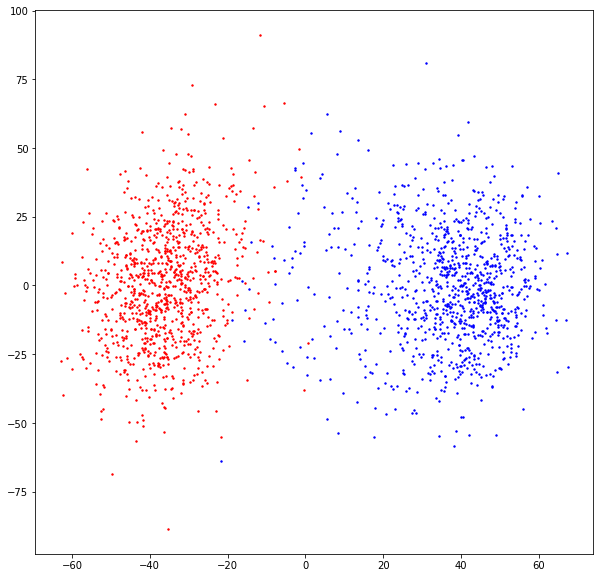

In [ ]:
# Lets make a scatter plot

plt.figure(figsize=(10,10));
plt.scatter(dog_components[0,:],dog_components[1,:],c='r',s=2);
plt.scatter(cat_components[0,:],cat_components[1,:],c='b',s=2);

In [ ]:
# Lets test the hypothesis that both of these 
# approaches result in the same final principle 
# components
print("Difference in first component: "+str(np.linalg.norm(Q2[:,0]-Q[:,0])));
print("Difference in second component: "+str(np.linalg.norm(Q2[:,1]-Q[:,1])));
print("Difference in second component: "+str(np.linalg.norm(Q2[:,2]-Q[:,2])));
print("Difference in second component: "+str(np.linalg.norm(Q2[:,3]-Q[:,3])));
print("Difference in second component: "+str(np.linalg.norm(Q2[:,4]-Q[:,4])));
# The first components match, the second don't, but we have a very poor 
# of the second component from our first approach

Difference in first component: 8.2576304e-07
Difference in second component: 1.1547014e-06
Difference in second component: 1.9999985
Difference in second component: 8.0745997e-07
Difference in second component: 1.3265234e-06


In [ ]:
# In theory, Q should be the eigenvectors we found through our 
# subspace iteration method. Lets project the cat and dog images
# on Q, and see where they are sent
cat_components = np.dot(cat_matrix,Q2);
dog_components = np.dot(dog_matrix,Q2);

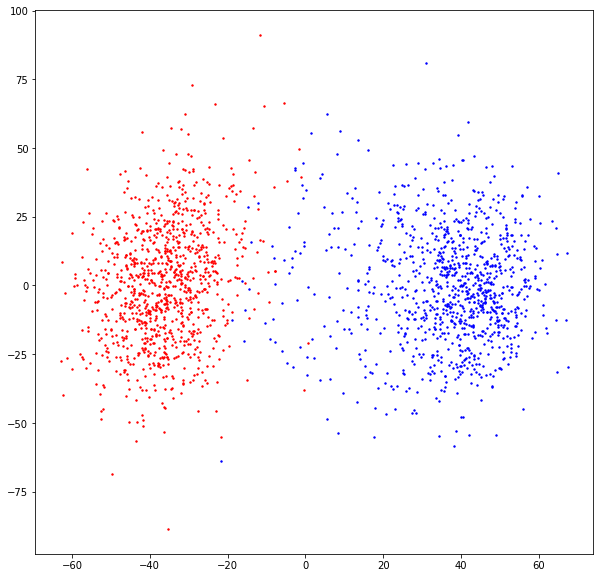

In [ ]:

plt.figure(figsize=(10,10));
# Dog Projections in Red, Cat Projections in Blue
plt.scatter(dog_components[:,0],dog_components[:,1],c='r',s=2);
plt.scatter(cat_components[:,0],cat_components[:,1],c='b',s=2);

In [ ]:
c1 = dog_components
c2 = cat_components

phi = np.concatenate((c1,c2),axis=0)
x = np.concatenate((np.ones((np.size(phi,0),1)),phi),axis=1)
y = np.concatenate((np.ones((np.size(c1,0),1)),np.zeros((np.size(c2,0),1))))
 
x1 = x
y1 = y

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

x = x_train
y = y_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


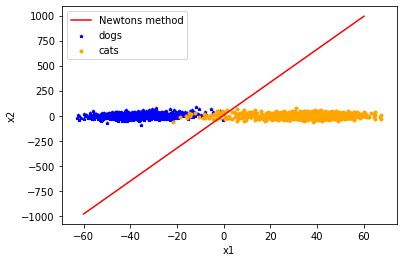

In [ ]:
max_ite_newton = 2; weight_vec = np.random.randn(6,1); lr = 0.1 #Here weight vector is 6*1 because we have % feature and remaining 1 is for bias
cost_val_newton = np.zeros((max_ite_newton,1))

for i in range(max_ite_newton):  #loop iterates for number of iteration and for more iteration model will overfit.
    h_x = 1/(1+np.exp(-x.dot(weight_vec)))
    cost_val_newton[i] = -(1/(np.size(x,0)))*sum(y*np.log(h_x) + (1-y)*np.log(1-h_x))
    grad = (1/(np.size(x,0)))*(x.T.dot((h_x-y)))
    # hessian matrix
    H = (1/(np.size(x,0)))*(x.T.dot(np.diag(h_x.reshape(np.size(x,0),))).dot(np.diag((1-h_x).reshape(np.size(x,0),))).dot(x)) # H is hessian matrix
    weight_vec = weight_vec - np.linalg.pinv(H).dot(grad) #This line changes the weights
    

plt.scatter(c1[:,0],c1[:,1],s= 9,color='blue',marker='*',label='dogs')
plt.scatter(c2[:,0],c2[:,1],s= 9,color='orange',marker='o',label='cats')
#Chart is ploted with only 2 features but line is calculated with 5 features
x_plot = np.linspace(-60, 60, 5)
y_plot = -weight_vec[0]/weight_vec[2] - (weight_vec[1]/weight_vec[2])*x_plot
plt.plot(x_plot,y_plot,'r',label='Newtons method' )
plt.xlabel('x1');plt.ylabel('x2')
plt.legend()
plt.show()

In [ ]:
print(x_test.shape)
print(weight_vec.shape)

(600, 6)
(6, 1)


In [ ]:
for t in x_test:
  predict = t.T.dot(weight_vec)
  ans = 'dog' if predict > 0 else 'cat'
  print(ans) 

cat
dog
dog
dog
cat
cat
dog
cat
dog
cat
dog
cat
dog
dog
dog
dog
dog
dog
dog
cat
dog
cat
cat
cat
cat
cat
cat
cat
dog
dog
dog
dog
cat
dog
cat
dog
cat
dog
cat
dog
dog
cat
cat
dog
cat
dog
dog
dog
dog
cat
cat
dog
cat
dog
dog
dog
cat
cat
cat
cat
cat
dog
cat
cat
dog
cat
dog
cat
dog
cat
dog
dog
cat
dog
dog
dog
cat
dog
dog
dog
dog
dog
cat
cat
cat
dog
cat
dog
dog
cat
dog
cat
dog
dog
cat
cat
dog
cat
cat
cat
dog
dog
dog
cat
dog
dog
dog
dog
dog
dog
dog
cat
dog
cat
dog
cat
cat
cat
cat
cat
cat
dog
cat
dog
cat
cat
dog
dog
cat
dog
dog
cat
dog
dog
cat
cat
cat
dog
dog
cat
cat
dog
cat
dog
cat
dog
dog
cat
dog
dog
cat
dog
dog
cat
dog
dog
dog
cat
dog
cat
dog
dog
dog
dog
cat
cat
cat
cat
dog
cat
cat
dog
cat
cat
cat
cat
dog
cat
dog
dog
dog
dog
cat
cat
dog
dog
cat
cat
cat
cat
dog
dog
cat
cat
dog
dog
cat
cat
cat
cat
cat
dog
cat
dog
dog
dog
cat
cat
cat
cat
cat
dog
dog
dog
cat
cat
cat
dog
dog
dog
cat
dog
dog
dog
cat
dog
dog
dog
cat
cat
dog
dog
cat
cat
cat
dog
cat
dog
cat
dog
dog
cat
dog
dog
cat
dog
dog
cat
dog
dog
